In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [ ]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


In [ ]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
# Set the directories containing the images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

In [ ]:
image_x = random.randint(0, 300)
image_x

41

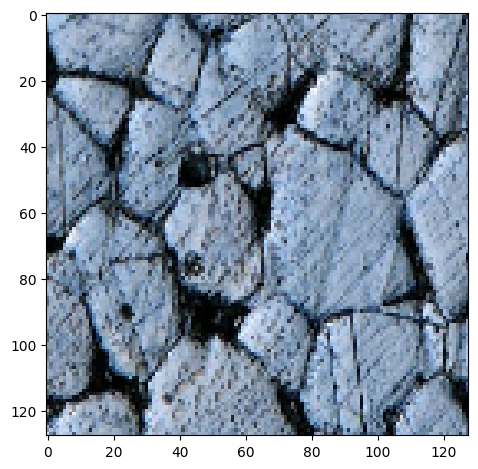

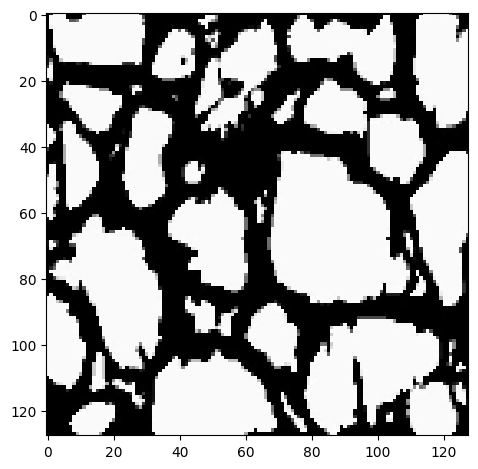

In [ ]:
# example
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

In [ ]:
import torch
import torch.nn as nn

class SegNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
            nn.Sigmoid()  # To squash output between 0 and 1 for binary classification
        )

    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)

        # Decoder
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the SegNet model
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the SegNet model
model = SegNet(IMG_CHANNELS, 1).to(device)


In [ ]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         295,168
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
        MaxPool2d-12          [-1, 256, 16, 16]               0
  ConvTranspose2d-13          [-1, 128, 32, 32]         131,200
      BatchNorm2d-14          [-1, 128,

In [ ]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(336, 128, 128, 3) (336, 128, 128, 3)


In [ ]:
# careful to run this cell only once (otherwise shape changes)
X_train = np.transpose(X_train, (0, 3, 1 , 2))
Y_train = np.transpose(Y_train, (0, 3, 1 , 2))
print(X_train.shape, Y_train.shape)

(336, 3, 128, 128) (336, 3, 128, 128)


In [ ]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

Y_t= np.any(Y_train, axis=1)
print(Y_t.shape)
Y_t = Y_t.reshape(336, 1, 128, 128)
print(Y_t.shape)


(336, 128, 128)
(336, 1, 128, 128)


In [ ]:
################################

# create the checkpoint path

checkpoint_path = '/content/checkpoint_path/GrainsTraining.ckpt'
os.makedirs("/content/checkpoint_path", exist_ok=True)
checkpoint_dir = os.path.dirname(checkpoint_path)


In [ ]:
# prompt: Make Dataset from data

from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(X_train, Y_t)



In [ ]:
# prompt: create train and validation dataset

from torch.utils.data import random_split

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Define DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            torch.save(model.state_dict(), self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

checkpointer = ModelCheckpoint(checkpoint_path)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        # print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model, val_loss)


Epoch [1/100], Train Loss: 0.4854, Val Loss: 0.4645
Checkpoint saved
Epoch [2/100], Train Loss: 0.3934, Val Loss: 0.4021
Checkpoint saved
Epoch [3/100], Train Loss: 0.3721, Val Loss: 0.3690
Checkpoint saved
Epoch [4/100], Train Loss: 0.3580, Val Loss: 0.3617
Checkpoint saved
Epoch [5/100], Train Loss: 0.3429, Val Loss: 0.3518
Checkpoint saved
Epoch [6/100], Train Loss: 0.3334, Val Loss: 0.3626
Epoch [7/100], Train Loss: 0.3253, Val Loss: 0.3337
Checkpoint saved
Epoch [8/100], Train Loss: 0.3195, Val Loss: 0.3374
Epoch [9/100], Train Loss: 0.3118, Val Loss: 0.3300
Checkpoint saved
Epoch [10/100], Train Loss: 0.3054, Val Loss: 0.3539
Epoch [11/100], Train Loss: 0.3012, Val Loss: 0.3411
Epoch [12/100], Train Loss: 0.2967, Val Loss: 0.3424
Epoch [13/100], Train Loss: 0.2904, Val Loss: 0.3303
Epoch [14/100], Train Loss: 0.2831, Val Loss: 0.3663
Epoch [15/100], Train Loss: 0.2765, Val Loss: 0.3516
Epoch [16/100], Train Loss: 0.2699, Val Loss: 0.3459
Epoch [17/100], Train Loss: 0.2651, Val Lo

In [ ]:
model.eval()

SegNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-0

In [ ]:
# Set model to evaluation mode
model.eval()

# Select a random index for demonstration
idx = random.randint(0, len(X_train))
print(f"Input data type: {X_train.dtype}")
# Perform predictions on training and validation data
with torch.no_grad():
    preds_train_tensor = model(torch.tensor(X_train[:int(X_train.shape[0]*0.9)], dtype=torch.float32).cuda())
    preds_val_tensor = model(torch.tensor(X_train[int(X_train.shape[0]*0.9):], dtype=torch.float32).cuda())

# Convert predictions to numpy arrays and apply thresholding
preds_train_np = (preds_train_tensor.cpu().numpy() > 0.5).astype(np.uint8)
preds_val_np = (preds_val_tensor.cpu().numpy() > 0.5).astype(np.uint8)

Input data type: uint8


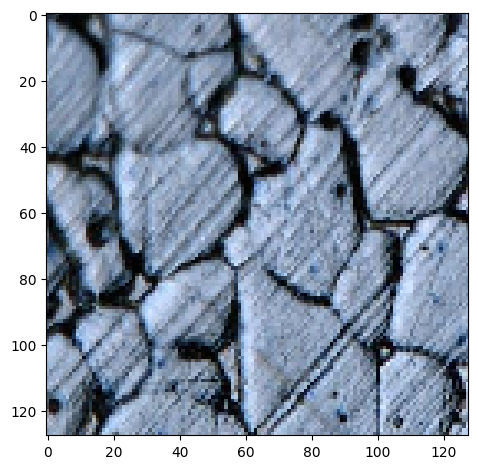

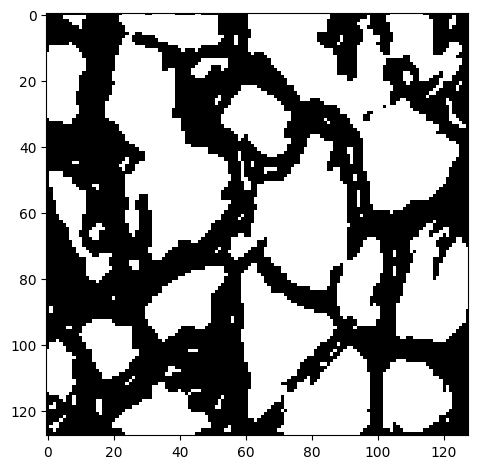

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


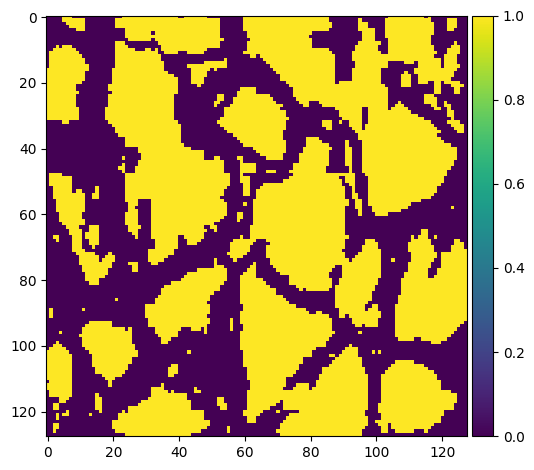

In [ ]:

ix = random.randint(0, len(preds_train_np))
imshow(np.transpose(X_train[ix], (1, 2, 0)))
plt.show()
imshow(np.squeeze(Y_t[ix]))
plt.show()
imshow(np.squeeze(preds_train_np[ix]))
plt.show()

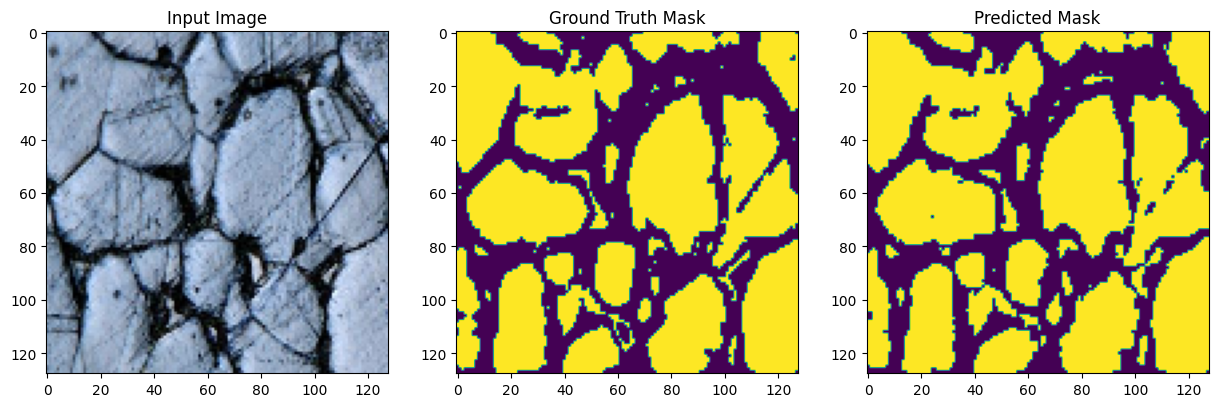

In [ ]:
import matplotlib.pyplot as plt
import random

def display_results(image, ground_truth_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title('Input Image')

    # Display ground truth mask
    axes[1].imshow(np.squeeze(ground_truth_mask))
    axes[1].set_title('Ground Truth Mask')

    # Display predicted mask
    axes[2].imshow(np.squeeze(predicted_mask))
    axes[2].set_title('Predicted Mask')

    plt.show()

# Select a random index for demonstration
idx = random.randint(0, len(X_train))

# Display results for the selected index
display_results(X_train[5], Y_t[5], preds_train_np[5])

In [ ]:
import numpy as np
import pandas as pd

def calculate_accuracy(y_true, y_pred):
    # Convert to boolean arrays
    y_true_bool = y_true.astype(bool)
    y_pred_bool = y_pred.astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(y_true_bool, y_pred_bool).sum()
    union = np.logical_or(y_true_bool, y_pred_bool).sum()

    # Calculate accuracy
    accuracy = intersection / union

    return accuracy

# Select a random index for demonstration
idx = 5

# Perform predictions on the validation data
with torch.no_grad():
    preds_val_tensor = model(torch.tensor(X_train[int(X_train.shape[0]*0.9):], dtype=torch.float32).to(device))

# Convert predictions to numpy arrays and apply thresholding
preds_val_np = (preds_val_tensor.cpu().numpy() > 0.5).astype(np.uint8)

# Calculate accuracy
accuracy = calculate_accuracy(Y_t[int(Y_t.shape[0]*0.9):], preds_val_np)

# Display results and accuracy in a table
results_df = pd.DataFrame({
    'Input Image': [np.transpose(X_train[idx], (1, 2, 0))],
    'Ground Truth Mask': [np.squeeze(Y_t[idx])],
    'Predicted Mask': [np.squeeze(preds_val_np[idx])],
    'Accuracy': [accuracy]
})

# Display the table
display(results_df)


,Input Image,Ground Truth Mask,Predicted Mask,Accuracy
0,"[[[132, 164, 198], [153, 181, 219], [153, 179,...","[[True, True, True, True, True, True, True, Tr...","[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.878244


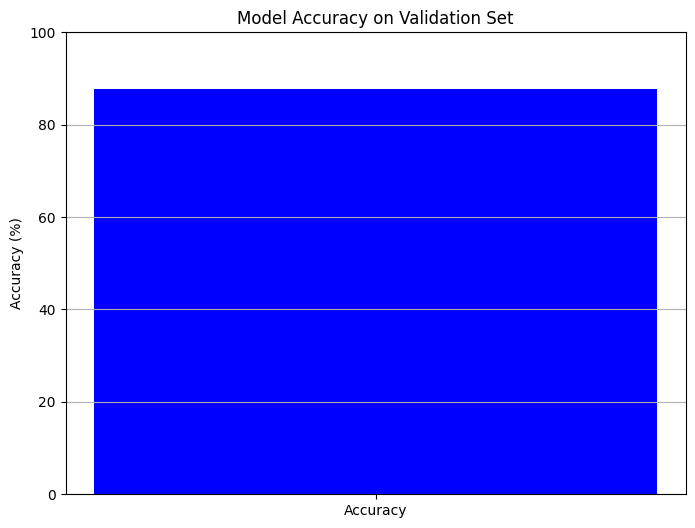

In [ ]:
import matplotlib.pyplot as plt

# Calculate accuracy percentage
accuracy_percentage = accuracy * 100

# Plot the accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Accuracy'], [accuracy_percentage], color='blue')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Validation Set')
plt.ylim(0, 100)  # Set y-axis limit to 0-100%
plt.grid(axis='y')
plt.show()

In [ ]:
# Function to calculate average grain size using the grain intercept method
def calculate_grain_size(num_grains, line_length):
    return num_grains / line_length

# Example data (replace with actual measurements)
num_grains = 1000  # Number of grains intersected by the line
line_length = 200  # Total length of the line

# Calculate average grain size
average_grain_size = calculate_grain_size(num_grains, line_length)

# Print the result
print("Average Grain Size:", average_grain_size)


Average Grain Size: 5.0


In [ ]:
# Evaluate the model on the validation set to get predictions
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply a threshold (e.g., 0.5 for binary classification)
        predicted_labels = (outputs > 0.5).float()

        # Calculate accuracy
        total_samples += targets.numel()
        total_correct += (predicted_labels == targets).sum().item()

accuracy = total_correct / total_samples
print("Prediction Accuracy:", accuracy)


Prediction Accuracy: 0.8316057990579044
